# Tugas Akhir Pemelajaran Mesin
### Tim Mencoba Learning
##### Pipeline Prediksi Cardiovascular Disease dengan Menggunakan Algoritma Klasifikasi 
##### oleh Kelly William (1606876784) - Kristianto (1606889856) - Marco Kenata (1606876771)
___

### Persiapan environment kerja
Persiapan ini dilakukan dengan meng-import beberapa library yang akan digunakan dalam pengerjaan proyek ini

In [1]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

---

### Persiapan dataset yang akan digunakan
Dataset yang digunakan adalah dataset "Cardiovascular Disease dataset" yang dapat ditemukan di Kaggle.com

In [2]:
cardio_dataset_raw = pd.read_csv("../input/cardio_train.csv",sep=";")

print("Dataset memiliki " + str(len(cardio_dataset_raw)) + " baris dan " + str(len(cardio_dataset_raw.columns)) + " kolom")
print()
print(cardio_dataset_raw.head())

Dataset memiliki 70000 baris dan 13 kolom

   id    age  gender  height  weight   ...    gluc  smoke  alco  active  cardio
0   0  18393       2     168    62.0   ...       1      0     0       1       0
1   1  20228       1     156    85.0   ...       1      0     0       1       1
2   2  18857       1     165    64.0   ...       1      0     0       0       1
3   3  17623       2     169    82.0   ...       1      0     0       1       1
4   4  17474       1     156    56.0   ...       1      0     0       0       0

[5 rows x 13 columns]


In [3]:
cardio_dataset_raw.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


---

### Preprocessing Dataset
Pada tahap ini, dataset akan di-preprocessing terlebih dahulu dengan urutan pengerjaan sebagai berikut:
* Pengecekan nilai null
* Pengecekan outlier
* Pengecekan tekanan sistole dan diastole
* Penghapusan row yang bermasalah
* Feature Engineering - Feature Creation - Membuat Fitur Body Mass Index (BMI)
* Feature Engineering - Feature Creation - Blood Pressure
* Feature Selection

#### Pengecekan nilai null

In [4]:
cardio_dataset_raw.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Dari pengecekan di atas, dataset tidak memiliki nilai null, sehingga preprocessing akan dilanjutkan ke tahap berikutnya.

#### Pengecekan outlier

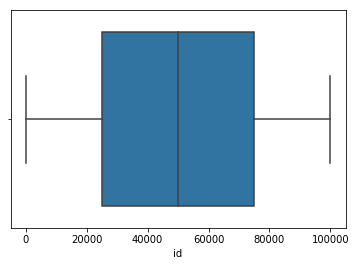

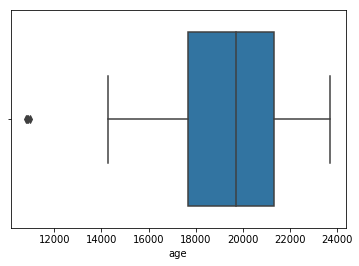

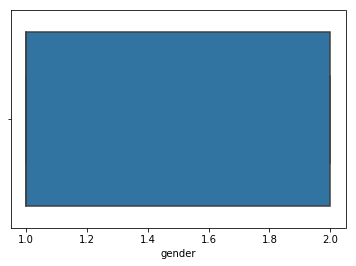

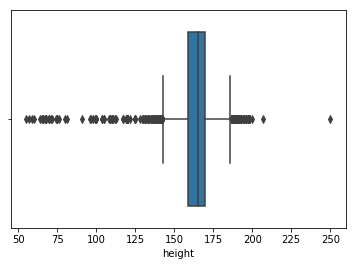

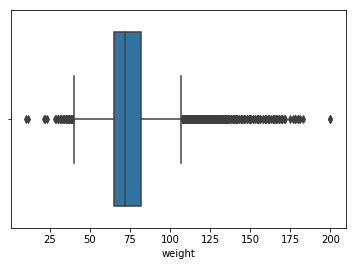

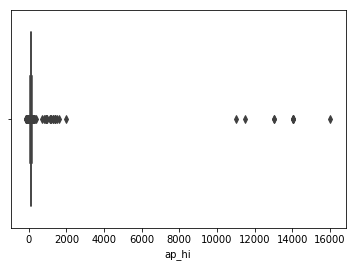

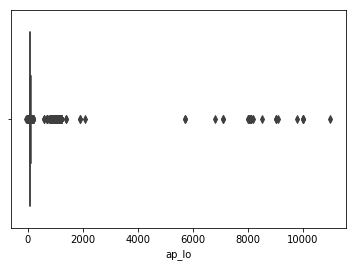

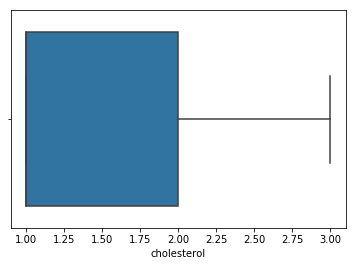

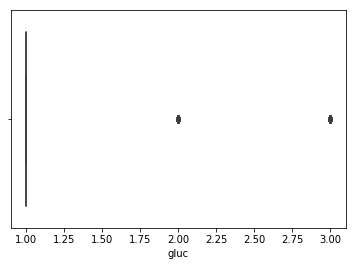

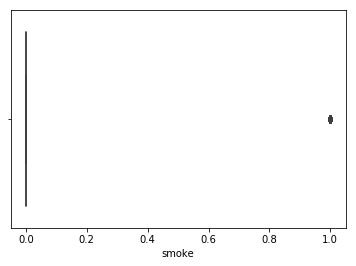

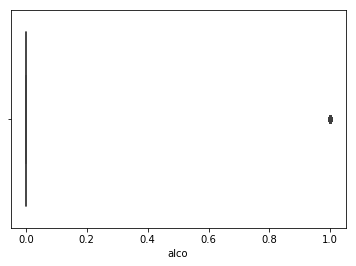

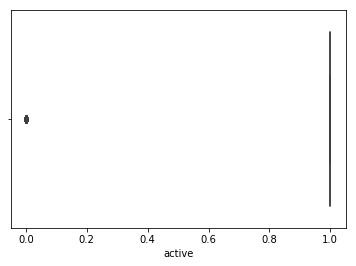

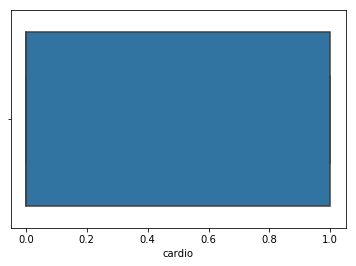

In [5]:
for col in cardio_dataset_raw.columns:
    sns.boxplot(x=cardio_dataset_raw[col])
    plt.show()

Dari pengecekan di atas, ditemukan outlier pada beberapa fitur, sehingga perlu dihapus pada tahapan berikutnya. Fitur yang akan dilakukan pendataan outlier adalah fitur-fitur yang bersifat numerical dan kontinu, yaitu age, height, weight, ap_hi, dan ap_lo. Kami menggunakan IQR untuk pendataan outlier karena metode tersebut juga digunakan dalam pengecekan outlier dengan menggunakan boxplot.

In [6]:
copy_of_cardio_dataset_raw = cardio_dataset_raw.copy()
check_outlier_column = ['age','height','weight','ap_hi','ap_lo']

# List untuk mendata row yang memiliki nilai outlier
row_with_outlier = []

# Menghitung IQR
Q1 = copy_of_cardio_dataset_raw.quantile(0.25)
Q3 = copy_of_cardio_dataset_raw.quantile(0.75)
IQR = Q3 - Q1
rangeBawah = (Q1 - 1.5 * IQR) // 1
rangeAtas = (Q3 + 1.5 * IQR) // 1

for i in range(len(check_outlier_column)):
    countOutlier = 0
    for j in range(len(copy_of_cardio_dataset_raw)):        
        #Cek apakah data lebih kecil dari Q1 - 1.5 * IQR
        if(copy_of_cardio_dataset_raw.loc[j][check_outlier_column[i]] < rangeBawah[check_outlier_column[i]]): 
            countOutlier = countOutlier + 1
            row_with_outlier.append(j)
            
        #Cek apakah data lebih besar dari Q3 + 1.5 * IQR
        elif(copy_of_cardio_dataset_raw.loc[j][check_outlier_column[i]] > rangeAtas[check_outlier_column[i]]):
            countOutlier = countOutlier + 1
            row_with_outlier.append(j)            
            
    print("Fitur " + check_outlier_column[i] + " memiliki " + str(countOutlier) + " data outlier")

Fitur age memiliki 4 data outlier
Fitur height memiliki 490 data outlier
Fitur weight memiliki 1810 data outlier
Fitur ap_hi memiliki 1435 data outlier
Fitur ap_lo memiliki 4632 data outlier


Pendataan row yang memiliki nilai outlier di atas akan disimpan dan diproses pada tahap menghapus row yang bermasalah.

#### Pengecekan tekanan sistole dan diastole

Secara logika, tekanan sistole (disimpan pada fitur ap_hi) harus lebih tinggi dari tekanan diastole (disimpan pada fitur ap_lo)

In [7]:
# List untuk mendata row yang memiliki nilai ap_hi lebih kecil dari ap_lo
row_with_error = []

for i in range(len(copy_of_cardio_dataset_raw)):
    if(copy_of_cardio_dataset_raw.loc[i]['ap_hi'] < copy_of_cardio_dataset_raw.loc[i]['ap_lo']):
        row_with_error.append(i)
    
print("Dataset memiliki " + str(len(row_with_error)) + " yang memiliki ap_lo yang lebih tinggi dari ap_hi")

Dataset memiliki 1234 yang memiliki ap_lo yang lebih tinggi dari ap_hi


Pendataan row yang memiliki nilai ap_hi lebih kecil dari ap_lo akan disimpan dan diproses pada tahap menghapus row yang bermasalah.

#### Penghapusan row yang bermasalah

In [8]:
# Menggabungkan row_with_outlier dengan row_with_error
row_with_errors = row_with_outlier + row_with_error

# Cek row yang memiliki outlier & error, hapus row duplikasi, kemudian sort row dari terbesar ke terkecil
row_with_errors = list(dict.fromkeys(row_with_errors))

# Sort row dari terbesar ke terkecil
for i in range(len(row_with_errors)):
    swap = i + np.argmax(row_with_errors[i:])
    (row_with_errors[i], row_with_errors[swap]) = (row_with_errors[swap], row_with_errors[i])

print("Secara total, terdapat " + str(len(row_with_errors)) + " baris yang harus dibersihkan")

Secara total, terdapat 7470 baris yang harus dibersihkan


Setelah data row yang bermasalah digabung, maka dilanjutkan dengan menghapus row tersebut dan disimpan ke dalam dataframe yang baru

In [9]:
cleaned_cardio_dataset = copy_of_cardio_dataset_raw.copy().drop(row_with_errors, axis=0)

#Reset row index
cleaned_cardio_dataset = cleaned_cardio_dataset.reset_index()

print("Dataset yang baru memiliki " + str(len(cleaned_cardio_dataset)) + " baris dan " + str(len(cleaned_cardio_dataset.columns)) + " kolom")
print()
print(cleaned_cardio_dataset.head(5))


Dataset yang baru memiliki 62530 baris dan 14 kolom

   index  id    age  gender  height   ...    gluc  smoke  alco  active  cardio
0      0   0  18393       2     168   ...       1      0     0       1       0
1      1   1  20228       1     156   ...       1      0     0       1       1
2      2   2  18857       1     165   ...       1      0     0       0       1
3      3   3  17623       2     169   ...       1      0     0       1       1
4      5   8  21914       1     151   ...       2      0     0       0       0

[5 rows x 14 columns]


#### Feature Engineering - Feature Creation - Membuat Fitur Body Mass Index (BMI)

Dari fitur height dan weight, dapat dibuat suatu fitur baru, yaitu Body Mass Index (BMI). Fitur BMI terdiri dari kategori yang dapat didefinisikan sebagai berikut:

| Kategori | BMI | Kategori (dalam angka) |
| :------: | :---: | :--------------------: |
| Underweight | < 18.5 | 0 |
| Normal | 18.5 - 24.9 | 1 |
| Overweight | 25 - 29.9 | 2 |
| Obesity | >30 | 3 | 

In [10]:
bmi = []

def convert_bmi_to_list(list_bmi):
    for i in range(len(list_bmi)):
        if(list_bmi[i] < 18.5):
            list_bmi[i] = 0 #Underweight
        elif(list_bmi[i] >= 18.5 and list_bmi[i] < 25):
            list_bmi[i] = 1 #Normal
        elif(list_bmi[i] >= 25 and list_bmi[i] < 30):
            list_bmi[i] = 2 #Overweight
        elif(list_bmi[i] >= 30):
            list_bmi[i] = 3 #Obesity
    return list_bmi

for i in range(len(cleaned_cardio_dataset)):
    bmi.append(cleaned_cardio_dataset.loc[i]['weight'] / (cleaned_cardio_dataset.loc[i]['height'] / 100) ** 2)
            
convert_bmi_to_list(bmi)

#Tambah fitur BMI ke dalam dataframe
cleaned_cardio_dataset['bmi'] = bmi

print(cleaned_cardio_dataset.head(5))

   index  id    age  gender  height ...   smoke  alco  active  cardio  bmi
0      0   0  18393       2     168 ...       0     0       1       0    1
1      1   1  20228       1     156 ...       0     0       1       1    3
2      2   2  18857       1     165 ...       0     0       0       1    1
3      3   3  17623       2     169 ...       0     0       1       1    2
4      5   8  21914       1     151 ...       0     0       0       0    2

[5 rows x 15 columns]


Setelah fitur BMI ditambahkan ke dalam dataframe, maka fitur height dan weight dapat dihapus dari dataframe.

In [11]:
cleaned_cardio_dataset = cleaned_cardio_dataset.drop(columns=['height', 'weight'])
cleaned_cardio_dataset.head(5)

,index,id,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,0,18393,2,110,80,1,1,0,0,1,0,1
1,1,1,20228,1,140,90,3,1,0,0,1,1,3
2,2,2,18857,1,130,70,3,1,0,0,0,1,1
3,3,3,17623,2,150,100,1,1,0,0,1,1,2
4,5,8,21914,1,120,80,2,2,0,0,0,0,2


#### Feature Engineering - Feature Creation - Blood Pressure

Dari fitur ap_hi dan ap_lo, dapat dibuat suatu fitur baru, yaitu Blood Pressure. Fitur Blood Pressure terdiri dari kategori yang dapat didefinisikan sebagai berikut (berdasarkan bloodpressureUK):

| Kategori | Blood Pressure | Kategori (dalam angka) |
| :------: | :---: | :--------------------: |
| Low | ap_hi < 90 or ap_lo < 60 | 0 |
| Normal | 90 <= ap_hi < 140 and 60 <= ap_lo < 90 | 1 |
| High | ap_hi >= 140 or ap_lo >= 90 | 2 |

In [12]:
bp = []

for i in range(len(cleaned_cardio_dataset)):
    if(cleaned_cardio_dataset.loc[i]['ap_hi'] < 90 or cleaned_cardio_dataset.loc[i]['ap_lo'] < 60):
        bp.append(0) #Low BP
    elif(cleaned_cardio_dataset.loc[i]['ap_hi'] >= 90 and cleaned_cardio_dataset.loc[i]['ap_hi'] < 140 and cleaned_cardio_dataset.loc[i]['ap_lo'] >= 60 and cleaned_cardio_dataset.loc[i]['ap_lo'] < 90):
        bp.append(1) #Normal BP
    elif(cleaned_cardio_dataset.loc[i]['ap_hi'] >= 140 and cleaned_cardio_dataset.loc[i]['ap_lo'] >= 90):
        bp.append(2) #High BP
    else:
        bp.append(-1) #Error

# Tambah fitur bp ke dalam dataframe
cleaned_cardio_dataset['bp'] = bp

print(cleaned_cardio_dataset.head(5))

   index  id    age  gender  ap_hi ...  alco  active  cardio  bmi  bp
0      0   0  18393       2    110 ...     0       1       0    1   1
1      1   1  20228       1    140 ...     0       1       1    3   2
2      2   2  18857       1    130 ...     0       0       1    1   1
3      3   3  17623       2    150 ...     0       1       1    2   2
4      5   8  21914       1    120 ...     0       0       0    2   1

[5 rows x 14 columns]


Dalam pengerjaan, dapat ditemukan suatu kasus dimana ap_hi = 130 dan ap_lo 90. Dari tabel yang diberikan, kasus tersebut tidak bisa dikategorikan ke Blood Pressure manapun, sehingga diputuskan agar data tersebut dihapus. Untuk mempermudah penghapusan data, kasus tersebut dikategorikan sebagai -1.

In [13]:
# List untuk mendata row yang memiliki kategori blood pressure -1
row_with_bp_error = []

for i in range(len(cleaned_cardio_dataset)):
    if(cleaned_cardio_dataset.loc[i]['bp'] == -1):
        row_with_bp_error.append(i)
        
print("Terdapat " + str(len(row_with_bp_error)) + " baris yang memiliki bp error")

Terdapat 8749 baris yang memiliki bp error


In [14]:
# Cek row yang memiliki bp error, hapus row duplikasi, kemudian sort row dari terbesar ke terkecil
row_with_bp_error = list(dict.fromkeys(row_with_bp_error))

# Sort row dari terbesar ke terkecil
for i in range(len(row_with_bp_error)):
    swap = i + np.argmax(row_with_bp_error[i:])
    (row_with_bp_error[i], row_with_bp_error[swap]) = (row_with_bp_error[swap], row_with_bp_error[i])

In [15]:
cleaned_cardio_dataset = cleaned_cardio_dataset.drop(row_with_bp_error, axis=0)

#Reset row index
cleaned_cardio_dataset = cleaned_cardio_dataset.reset_index()

print("Dataset yang baru memiliki " + str(len(cleaned_cardio_dataset)) + " baris dan " + str(len(cleaned_cardio_dataset.columns)) + " kolom")
print()
print(cleaned_cardio_dataset.head(5))

Dataset yang baru memiliki 53781 baris dan 15 kolom

   level_0  index  id    age  gender ...  alco  active  cardio  bmi  bp
0        0      0   0  18393       2 ...     0       1       0    1   1
1        1      1   1  20228       1 ...     0       1       1    3   2
2        2      2   2  18857       1 ...     0       0       1    1   1
3        3      3   3  17623       2 ...     0       1       1    2   2
4        4      5   8  21914       1 ...     0       0       0    2   1

[5 rows x 15 columns]


Setelah fitur BMI ditambahkan ke dalam dataframe dan sudah menghapus row dengan blood pressure yang bermasalah, maka fitur ap_hi dan ap_lo dapat dihapus dari dataframe.

In [16]:
cleaned_cardio_dataset = cleaned_cardio_dataset.drop(columns=['ap_hi', 'ap_lo'])
cleaned_cardio_dataset.head(5)

,level_0,index,id,age,gender,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp
0,0,0,0,18393,2,1,1,0,0,1,0,1,1
1,1,1,1,20228,1,3,1,0,0,1,1,3,2
2,2,2,2,18857,1,3,1,0,0,0,1,1,1
3,3,3,3,17623,2,1,1,0,0,1,1,2,2
4,4,5,8,21914,1,2,2,0,0,0,0,2,1


#### Feature Selection

Proses selanjutnya adalah Feature Selection dengan menggunakan seaborn heatmap dan dihitung korelasi antar fitur dengan menggunakan Pearson's Correlation Coefficients. Dari dataframe tersebut, label yang dipilih adalah cardio, sehingga akan dipilih fitur dengan korelasi yang cukup baik dengan label cardio tersebut.

<function matplotlib.pyplot.show(*args, **kw)>

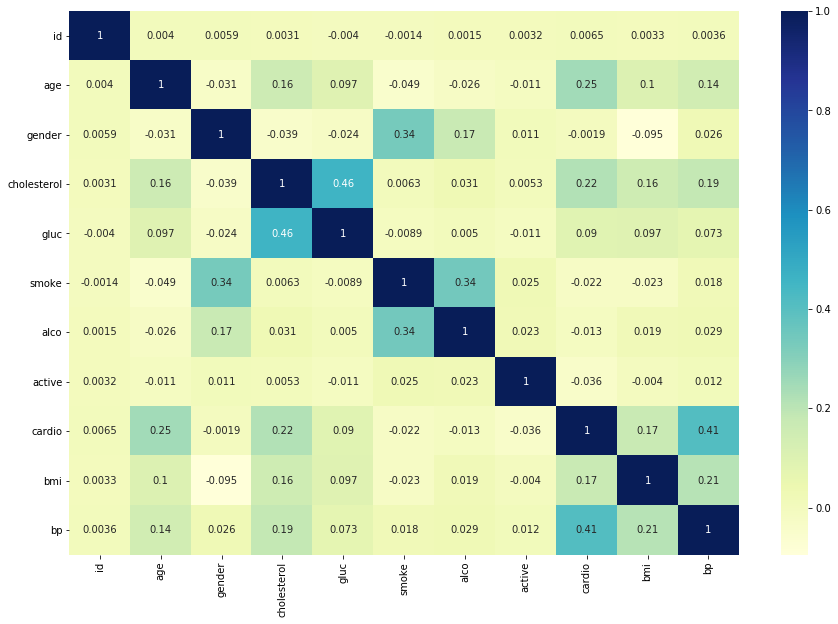

In [17]:
# Drop kolom index 
cleaned_cardio_dataset = cleaned_cardio_dataset.drop(columns=['level_0', 'index'])

# Plotting heatmap
sns.heatmap(cleaned_cardio_dataset.corr(),annot=True,cmap='YlGnBu')
fig=plt.gcf()
fig.set_size_inches(15,10)
plt.show

Dari plotting heatmap di atas, fitur yang memiliki korelasi yang cukup baik dengan label cardio adalah age, cholesterol, bmi, dan bp, sehingga fitur tersebut dipilih untuk digunakan di dalam model.

In [18]:
final_cardio = cleaned_cardio_dataset.copy().drop(columns=['id', 'gender', 'smoke', 'alco', 'active'])
final_cardio.head(5)

,age,cholesterol,gluc,cardio,bmi,bp
0,18393,1,1,0,1,1
1,20228,3,1,1,3,2
2,18857,3,1,1,1,1
3,17623,1,1,1,2,2
4,21914,2,2,0,2,1


In [19]:
final_cardio.describe()

,age,cholesterol,gluc,cardio,bmi,bp
count,53781.000000,53781.000000,53781.000000,53781.000000,53781.000000,53781.000000
mean,19426.114966,1.333817,1.213719,0.463286,1.820940,1.229523
std,2467.983842,0.655951,0.560168,0.498655,0.790795,0.420530
min,14282.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,17615.000000,1.000000,1.000000,0.000000,1.000000,1.000000
50%,19683.000000,1.000000,1.000000,0.000000,2.000000,1.000000
75%,21292.000000,1.000000,1.000000,1.000000,2.000000,1.000000
max,23713.000000,3.000000,3.000000,1.000000,3.000000,2.000000


---

### Prediction

Pemisahan label dan fitur dari dataframe

In [20]:
y_cardio = final_cardio['cardio']
x_cardio = final_cardio.drop('cardio', axis=1)

In [21]:
y_cardio.head(5)

0    0
1    1
2    1
3    1
4    0
Name: cardio, dtype: int64

In [22]:
x_cardio.head(5)

,age,cholesterol,gluc,bmi,bp
0,18393,1,1,1,1
1,20228,3,1,3,2
2,18857,3,1,1,1
3,17623,1,1,2,2
4,21914,2,2,2,1


In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_cardio, y_cardio, test_size=0.4, random_state=32)
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=0.5, random_state=32)

In [24]:
print("Data training {}, data testing {}, data validation {}".format(x_train.shape, x_test.shape, x_validation.shape))

Data training (32268, 5), data testing (10756, 5), data validation (10757, 5)


In [25]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, precision_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

RandomForestClassifier
Accuracy score:  0.6435477872815173
Log loss:  12.311555149119442
Confusion matrix: 
[[3990 1774]
 [2060 2932]]
Precision score:  0.6230344241393965
F1 score:  0.604660754794803


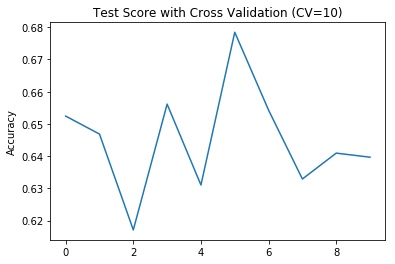




GradientBoostingClassifier
Accuracy score:  0.7251766455931573
Log loss:  9.492127581842903
Confusion matrix: 
[[4887  877]
 [2079 2913]]
Precision score:  0.7686015831134565
F1 score:  0.6634024140286952


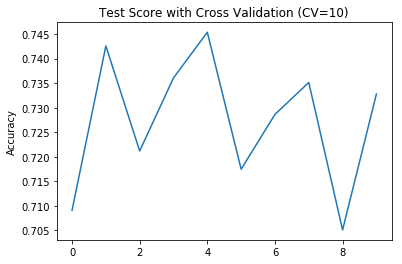




MLPClassifier
Accuracy score:  0.7253625883227965
Log loss:  9.485702225215727
Confusion matrix: 
[[4929  835]
 [2119 2873]]
Precision score:  0.7748112189859763
F1 score:  0.6604597701149425


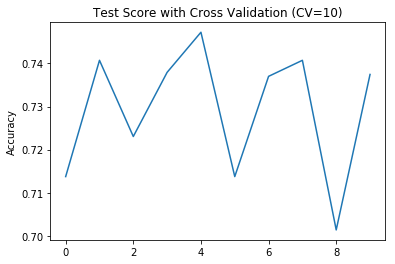

In [26]:
classifiers = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    MLPClassifier()
]

for classifier in classifiers:
    model = Pipeline([("Normalize", StandardScaler()), ("Classifier", classifier)])
    model.fit(x_train, y_train)   
    y_pred = model.predict(x_test)
    cf_name = type(classifier).__name__
    print(cf_name)
    print("Accuracy score: ", model.score(x_test, y_test))
    print("Log loss: ", log_loss(y_test, y_pred))
    print("Confusion matrix: ")
    print(confusion_matrix(y_test, y_pred))
    print("Precision score: ", precision_score(y_test, y_pred))
    print("F1 score: ", f1_score(y_test, y_pred))
    
    cv_results = cross_validate(model, x_validation, y_validation, cv=10)
    plt.plot(cv_results["test_score"])
    plt.title("Test Score with Cross Validation (CV=10)")
    plt.ylabel("Accuracy")
    plt.show()
    
    print("\n\n")
